# Table of Contents
 <p><div class="lev1"><a href="#Multiband-Resting-State-fMRI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multiband Resting-State fMRI</a></div><div class="lev2"><a href="#Summary-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Summary</a></div><div class="lev2"><a href="#Methodology-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Methodology</a></div><div class="lev1"><a href="#Measure-Dynamic-Functional-Connectivity-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Measure Dynamic Functional Connectivity</a></div><div class="lev2"><a href="#Initialize-Environment-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev2"><a href="#Generate-List-of-Data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Generate List of Data</a></div><div class="lev2"><a href="#Design-and-Run-DyNe-Pipeline-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Design and Run DyNe Pipeline</a></div><div class="lev3"><a href="#Plot-Sample-BOLD-Signal-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Plot Sample BOLD Signal</a></div><div class="lev3"><a href="#Generate-Pipe-Definitions-(JSON-Files)-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Generate Pipe Definitions (JSON Files)</a></div><div class="lev3"><a href="#Generate-Pipeline-Definitions-(JSON-File)-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Generate Pipeline Definitions (JSON File)</a></div><div class="lev3"><a href="#Run-the-Pipeline-(in-Parallel)-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Run the Pipeline (in Parallel)</a></div><div class="lev2"><a href="#Plot-Adjacency-Matrices-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Plot Adjacency Matrices</a></div><div class="lev3"><a href="#Plot-Configuration-Matrix-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Plot Configuration Matrix</a></div>

# Multiband Resting-State fMRI

## Summary

*__Introduction__*

  * The brain is a complex organ that manifests a network of interactions, at the finer scale, between neurons and neuron populations, and at the meso-scale, between large functional domains. Over time, the pattern of interactions between brain regions change, describing a dynamic system capable of supporting cognition during tasks and at rest.
  
  * Recent advances in functional brain imaging make it possible to acquire images from multiple brain slices simultaneously, known as multiband imaging. 
  
  * Multiband imaging improves the sampling frequency of the blood oxygenation level dependant (BOLD) signal from $\approx$0.5 Hz to $\approx$2.0 Hz. With faster sampling of the BOLD signal, we are able to examine functional interactions across whole brain at unprecendent temporal resolution.
  
  * Previous work has indicated that functional associations between low-frequency components of the fMRI signal (0–0.15 Hz) can be attributed to task-related functional connectivity, whereas associations between high-frequency components (0.2–0.4 Hz) cannot. This frequency specificity of task-relevant functional connectivity is likely to be due at least in part to the hemodynamic response function, which might act as a noninvertible bandpass filter on underlying neural activity.
  
*__References__*
  - Pan, Wen-Ju, et al. "Infraslow LFP correlates to resting-state fMRI BOLD signals." Neuroimage 74 (2013): 288-297.
  - F. T. Sun, L. M. Miller, and M. D’Esposito, “Measuring interregional functional connectivity using coherence and partial coherence analyses of fMRI data.” Neuroimage 21 (2004): 647–658.



## Methodology

*__Multi-Taper Coherence__*

  * Multi-Taper methods are designed to limit the leakage of spectral power from other frequency bands into the frequency bands of interest. This is a critical concern when spectral properties of the signal are computed in discrete temporal windows. Different shapes of the temporal window can cause unwanted effects in the Fourier domain.

  * The choice of window length and shape impacts the allowable frequency resolution of the signal power spectrum. Slepian sequences, or orthogonal, wave-like eigenfunctions, give the optimal windowing to achieve a spectral bandwidth resolution on the interval $[-W, W]$. To achieve this resolution, multiple sequences are required, such that the optimal number of Slepian sequences, $k\approx2WT$, where $k$ is the number of Slepian sequences, $2W$ is the desired spectral resolution bandwidth, and $T$ is the duration of the window.
  
  * Suppose we wanted to estimate dynamic functional connectivity of fMRI in 30 second windows between 0.034 Hz and 0.167 Hz (i.e. a bandwidth resolution of 0.133 Hz), then the time-bandwidth product would be $4.0 = 0.133 Hz * 30 sec$, and the optimal number of tapers would be $2*4.0-1 = 7$.
  
   

# Measure Dynamic Functional Connectivity

## Initialize Environment

In [2]:
try:
    %load_ext autoreload
    %autoreload 2
    %reset
except:
    print 'NOT IPYTHON'

from __future__ import division

import os
import sys
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

sys.path.append('/Users/akhambhati/Developer/hoth_research/Echobase')
import Echobase

rcParams = Echobase.Plotting.fig_format.update_rcparams(rcParams)

path_CoreData = '/Users/akhambhati/Remotes/CORE.fMRI_multiband.mmattar/restdata'
path_PeriphData = '/Users/akhambhati/Remotes/RSRCH.NMF_Subnetworks'
path_ExpData = path_PeriphData + '/e01-Dyne_FuncNetw'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/Users/akhambhati/Developer/miniconda2/envs/echobase/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/akhambhati/Developer/miniconda2/envs/echobase/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Generate List of Data

In [3]:
subjs = [full_subj_path.split('/')[-1]
         for full_subj_path in glob.iglob('{}/Subjects/*'.format(path_CoreData))]

subj_ids = {}
proc_path = []
for subj in subjs:
    run_path = '{}/Subjects/{}/*'.format(path_CoreData, subj)

    subj_ids[subj] = []
    run_ids = {}
    for full_run_path in glob.iglob(run_path):
        subj_ids[subj].append(full_run_path.split('/')[-1])

## Design and Run DyNe Pipeline

### Plot Sample BOLD Signal

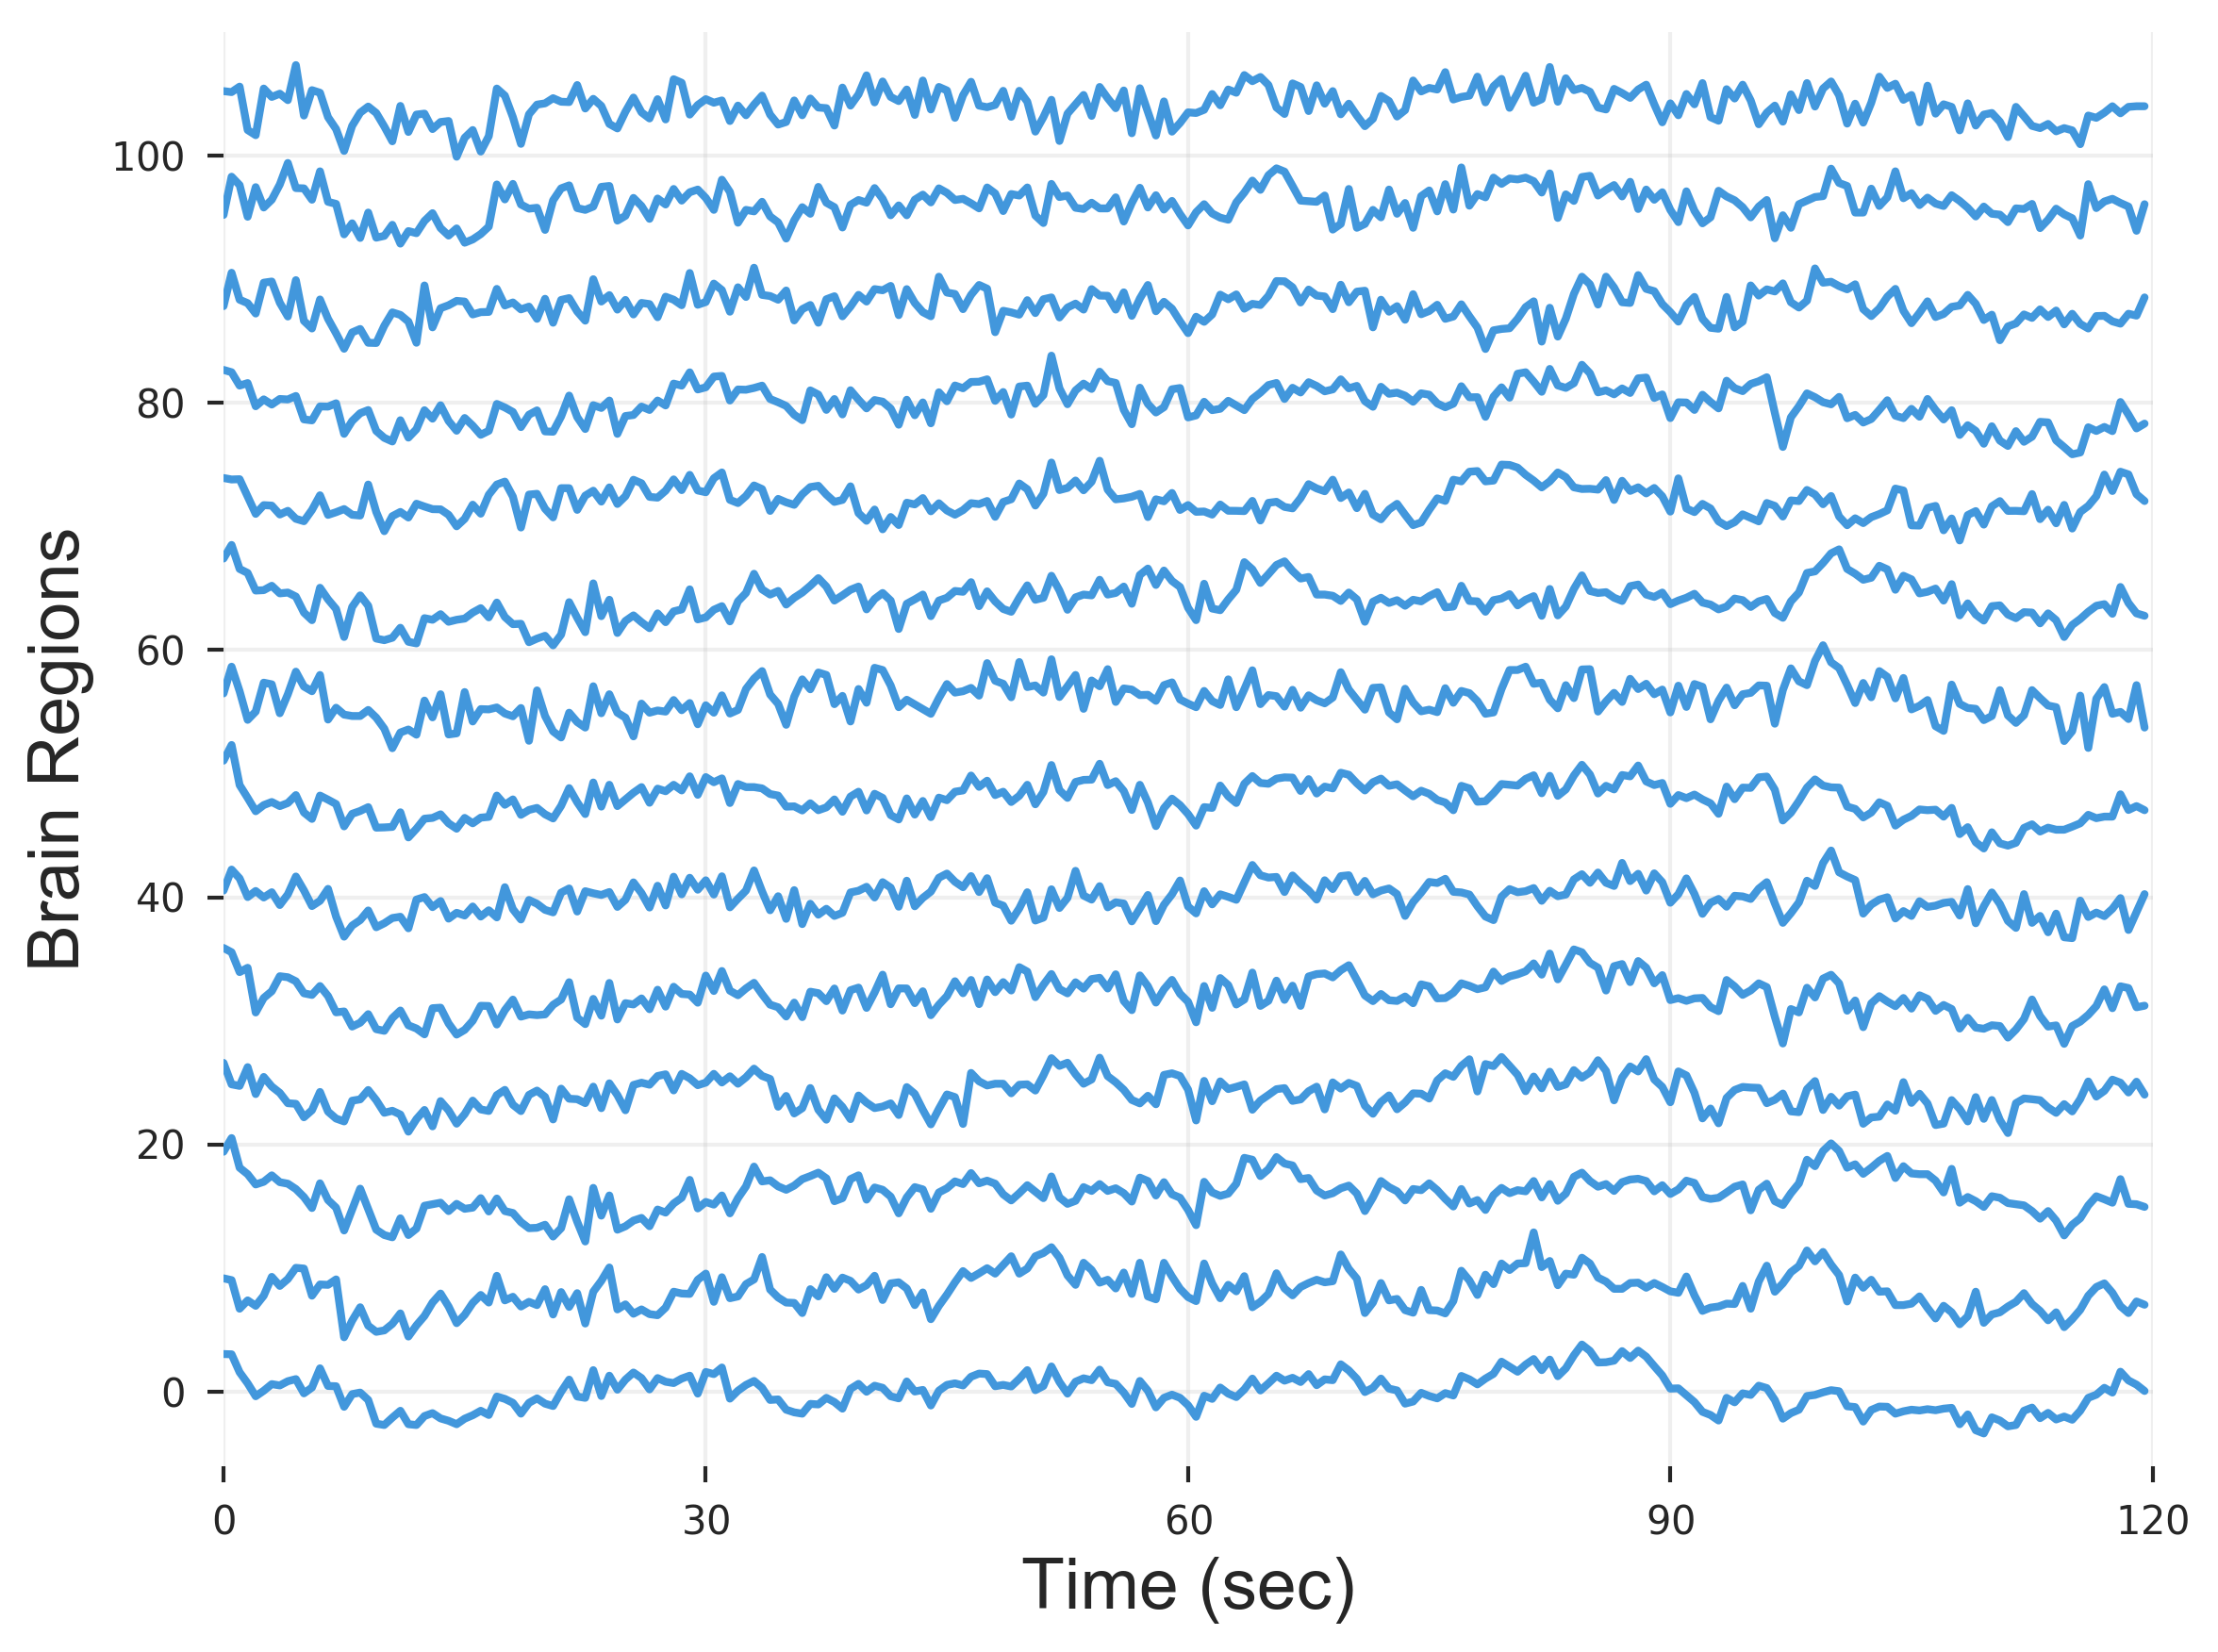

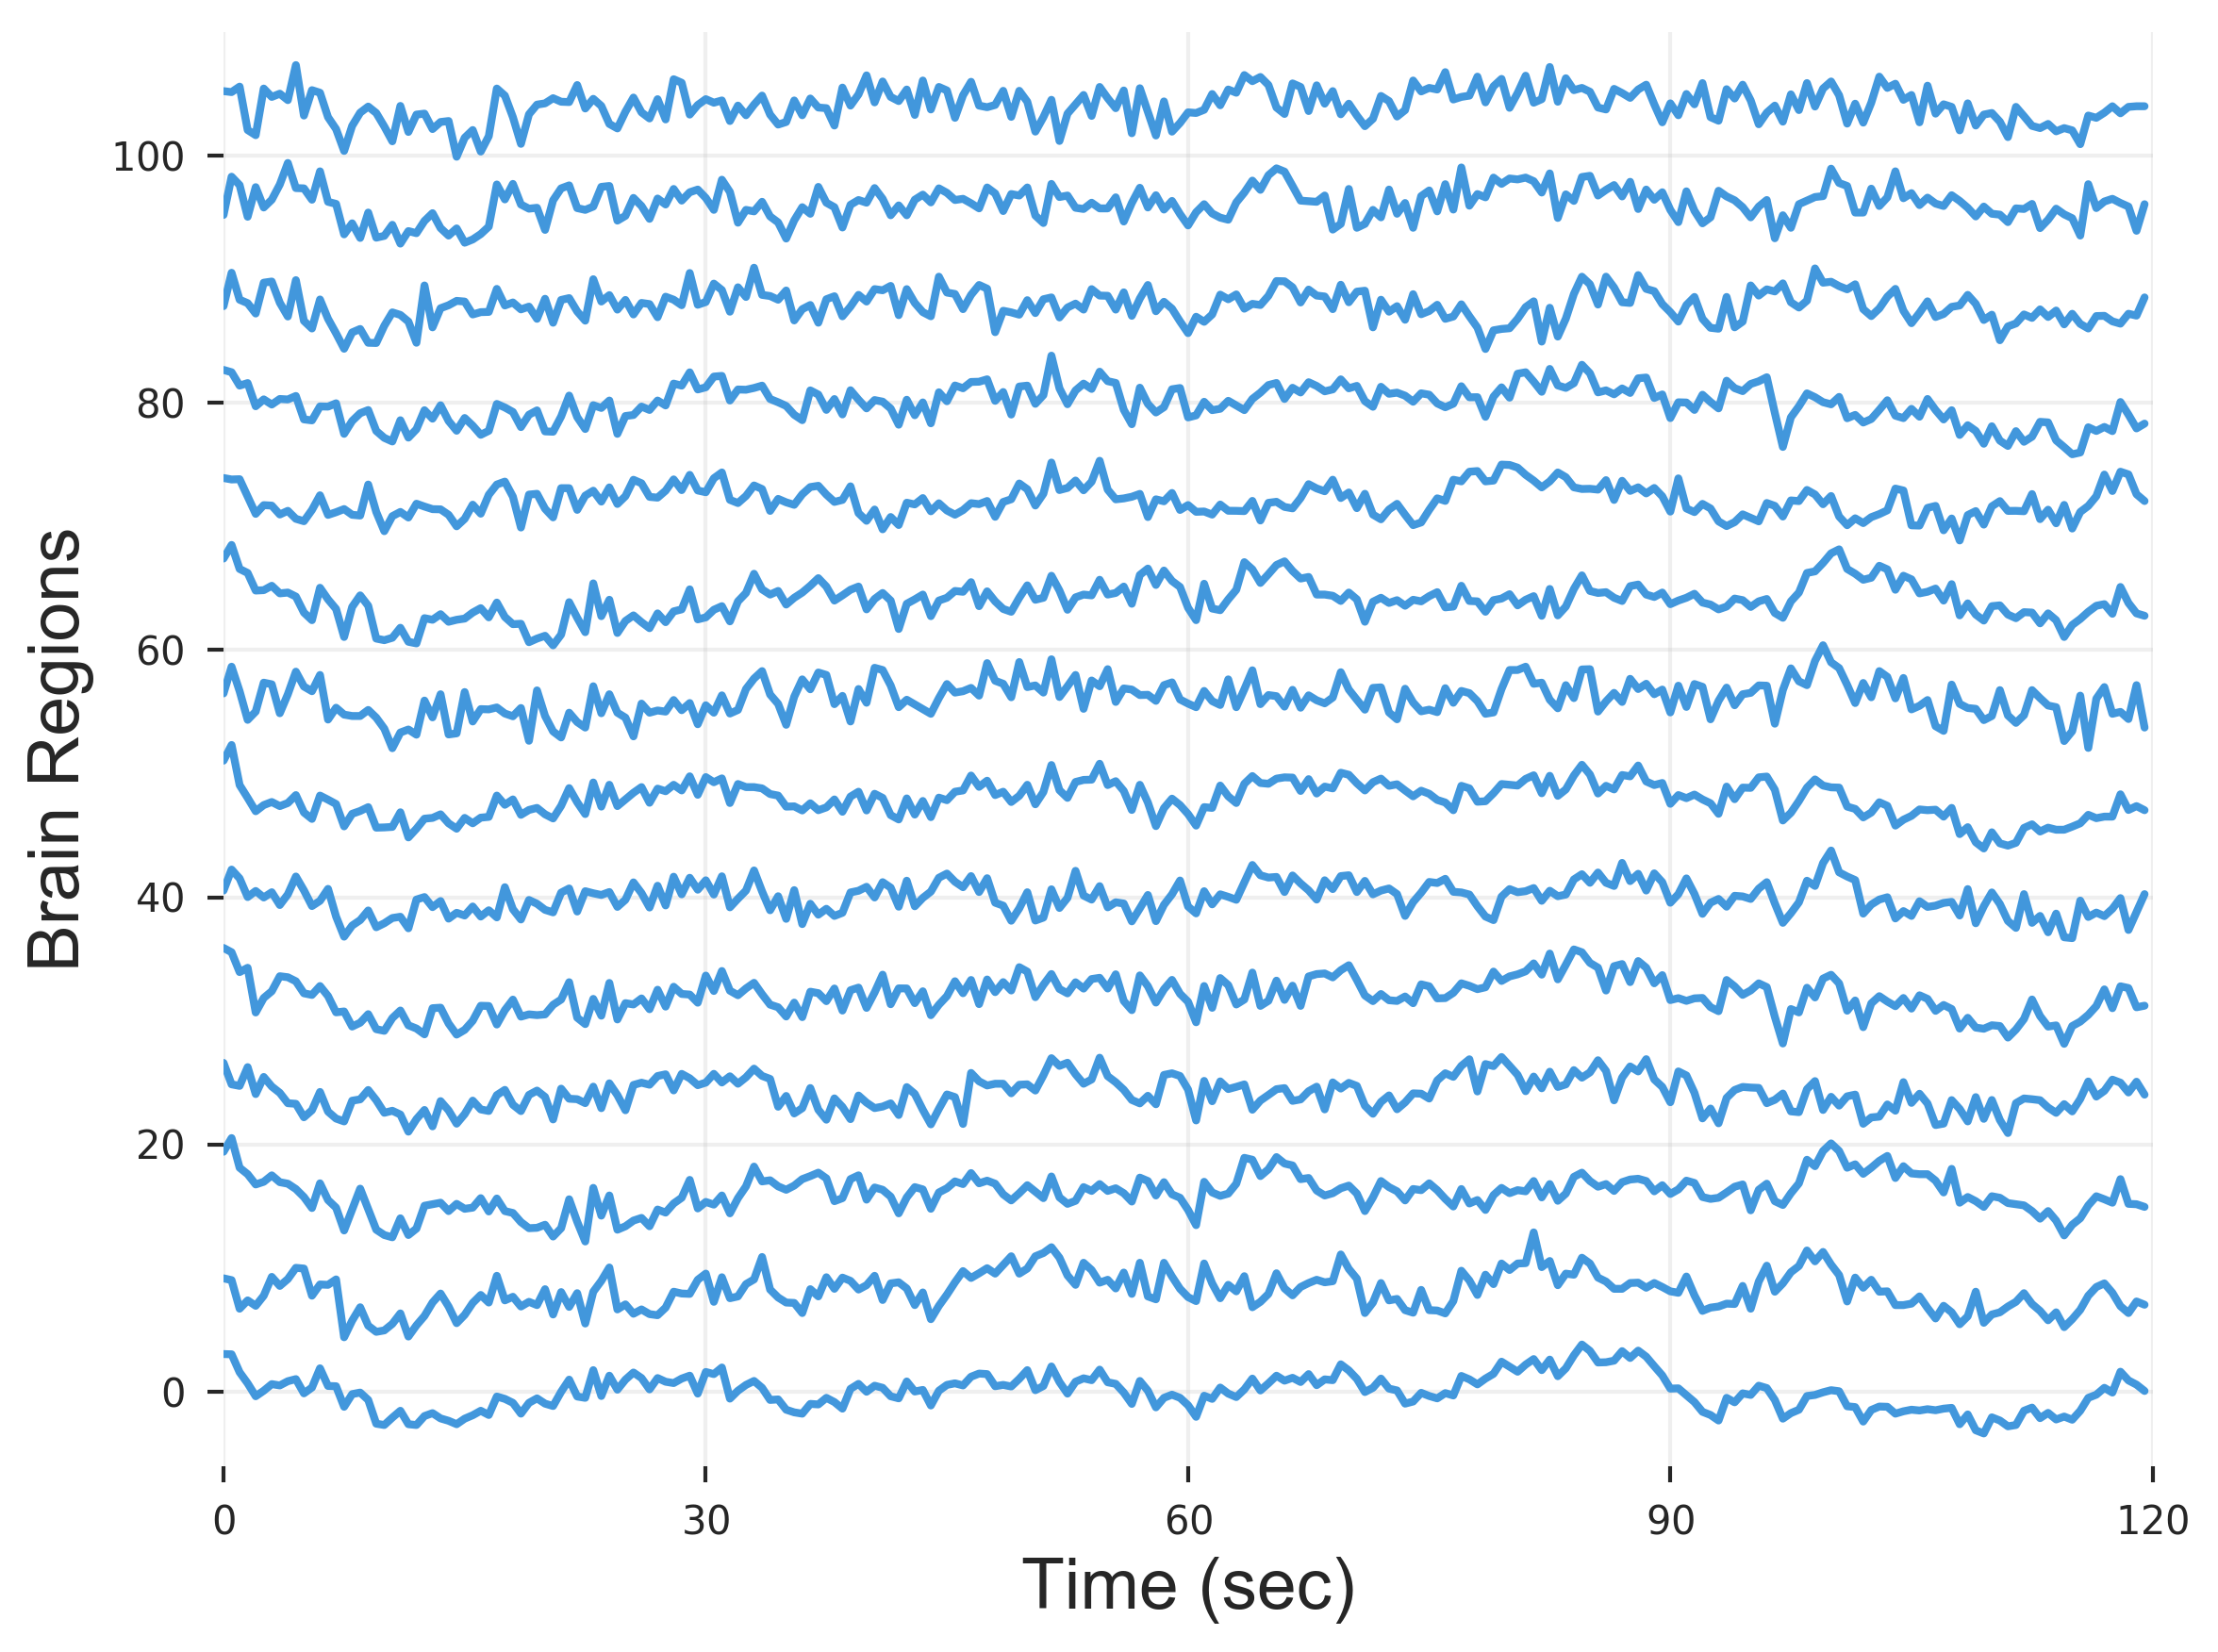

In [8]:
#%matplotlib inline

for subj, dates in subj_ids.items():
    for date_id in dates:
        
        # Generate path to the input fMRI clip
        proc_item = '{}/Subjects/{}/{}/HOA112.csv'.format(path_CoreData,
                                                          subj, date_id)
        if not os.path.exists(proc_item):
            raise IOError('Procesing item: {}, not found'.format(proc_item))
            
        df = pd.read_csv(proc_item)
        norm_df = (df - df.mean(axis=0)).as_matrix()
        norm_df = norm_df / (0.75*np.std(norm_df, axis=0))
        
        n_samp = df.shape[0]
        Fs = 2.0
        time = 120
        samples = np.arange(0, time*Fs)
        
        # Construct result figure
        plt.figure()
        ax = plt.subplot(111)
        
        ch_subset = np.arange(0, df.shape[1], 8)
        for ch in ch_subset:
            ax.plot(samples/Fs, ch + norm_df[map(int, samples), ch], color=[66/256., 152/256., 221./256])
            #ax.plot(time, ch + norm_df[:, ch]/(0.75*norm_df[:, ch].max()), )
            #break

        ax.set_ylim([ch_subset.min()-4, ch_subset.max()+4])

        # Axis Settings
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks([0, 30, 60, 90, 120])
        ax.set_ylim([ch_subset.min()-6, ch_subset.max()+6])
        ax.set_ylabel('Brain Regions')
        ax.set_xlabel('Time (sec)')
        
        plt.savefig('./e01-Figures/BOLD_Signal.svg')
        plt.show()
        break
    break

### Generate proc_list

In [38]:
proc_list = []

for subj, dates in subj_ids.items():
    for date_id in dates:
        
        # Generate path to the input fMRI clip
        bold_path = '{}/Subjects/{}/{}/HOA112.csv'.format(path_CoreData,
                                                          subj, date_id)
        adj_path = '{}/Adjacency.{}.{}.npz'.format(path_ExpData,
                                                   subj, date_id)
        
        if not os.path.exists(bold_path):
            raise IOError('Procesing item: {}, not found'.format(bold_path))
            
        proc_list.append({'bold_path': bold_path,
                          'adj_path': adj_path})

### Echobase Pipeline for adajcency matrices

In [40]:
# Parameters
params = {'signal': {},
          'coherence': {}}

# Signal processing
params['signal'] = {'fs': 2,
                    'win_len': 30.0,
                    'win_disp': 30.0}

# Coherence measurement
params['coherence'] = {'time_band': 2.5,
                       'n_taper': 4,
                       'cf': [0.034, 0.20]}


def measure_coherence(proc_item):
    print('\nProcessing: {}'.format(proc_item['bold_path']))
    
    # Load the BOLD Signal from CSV
    df = np.array(np.genfromtxt(proc_item['bold_path'], delimiter=','),
                  dtype=np.float)
    
    n_sample, n_node = df.shape
    
    
    # Check window size and displacement
    n_win_len = int(params['signal']['win_len'] * params['signal']['fs'])
    n_win_disp = int(params['signal']['win_disp'] * params['signal']['fs'])
    if n_win_len > n_sample:
        raise ValueError('win_len cannot be longer than signal duration')
    n_wins = int((n_sample - n_win_len) /
                 n_win_disp) + 1
            
    # Initialize a time-varying adjacency matrix
    adj_matr = np.zeros((n_wins, n_node, n_node))
    
    # Iterate over windows
    for win_id, idx in enumerate(range(0, n_wins * n_win_disp, n_win_disp)):
        win = df[idx:idx+n_win_len, :]
        adj_matr[win_id, ...] = Echobase.Network.Functional.coherence.multitaper(win, params['signal']['fs'],
                                                                                 **params['coherence'])
    
    # Save the output
    np.savez(proc_item['adj_path'], adj_matr=adj_matr)

### Run the Pipeline

In [45]:
from multiprocessing import Pool
parallel_run = True    
    
if parallel_run:
    mp = Pool(6)
    mp.map(measure_coherence, proc_list)
else:
    map(measure_coherence, proc_list)


Processing: /Users/akhambhati/Remotes/CORE.fMRI_multiband.mmattar/restdata/Subjects/b031615b/20150316/HOA112.csv
Processing: /Users/akhambhati/Remotes/CORE.fMRI_multiband.mmattar/restdata/Subjects/A010615C/20150106/HOA112.csv
Processing: /Users/akhambhati/Remotes/CORE.fMRI_multiband.mmattar/restdata/Subjects/j032315w/20150323/HOA112.csv
Processing: /Users/akhambhati/Remotes/CORE.fMRI_multiband.mmattar/restdata/Subjects/M030215R/20150302/HOA112.csv
Processing: /Users/akhambhati/Remotes/CORE.fMRI_multiband.mmattar/restdata/Subjects/h010615p/20150106/HOA112.csv
Processing: /Users/akhambhati/Remotes/CORE.fMRI_multiband.mmattar/restdata/Subjects/a012615k/20150126/HOA112.csv






Processing: /Users/akhambhati/Remotes/CORE.fMRI_multiband.mmattar/restdata/Subjects/b031615b/20150317/HOA112.csv

Processing: /Users/akhambhati/Remotes/CORE.fMRI_multiband.mmattar/restdata/Subjects/j032315w/20150324/HOA112.csv

Processing: /Users/akhambhati/Remotes/CORE.fMRI_multiband.mmattar/restdata/Subjects/A01

## Plot Adjacency Matrices

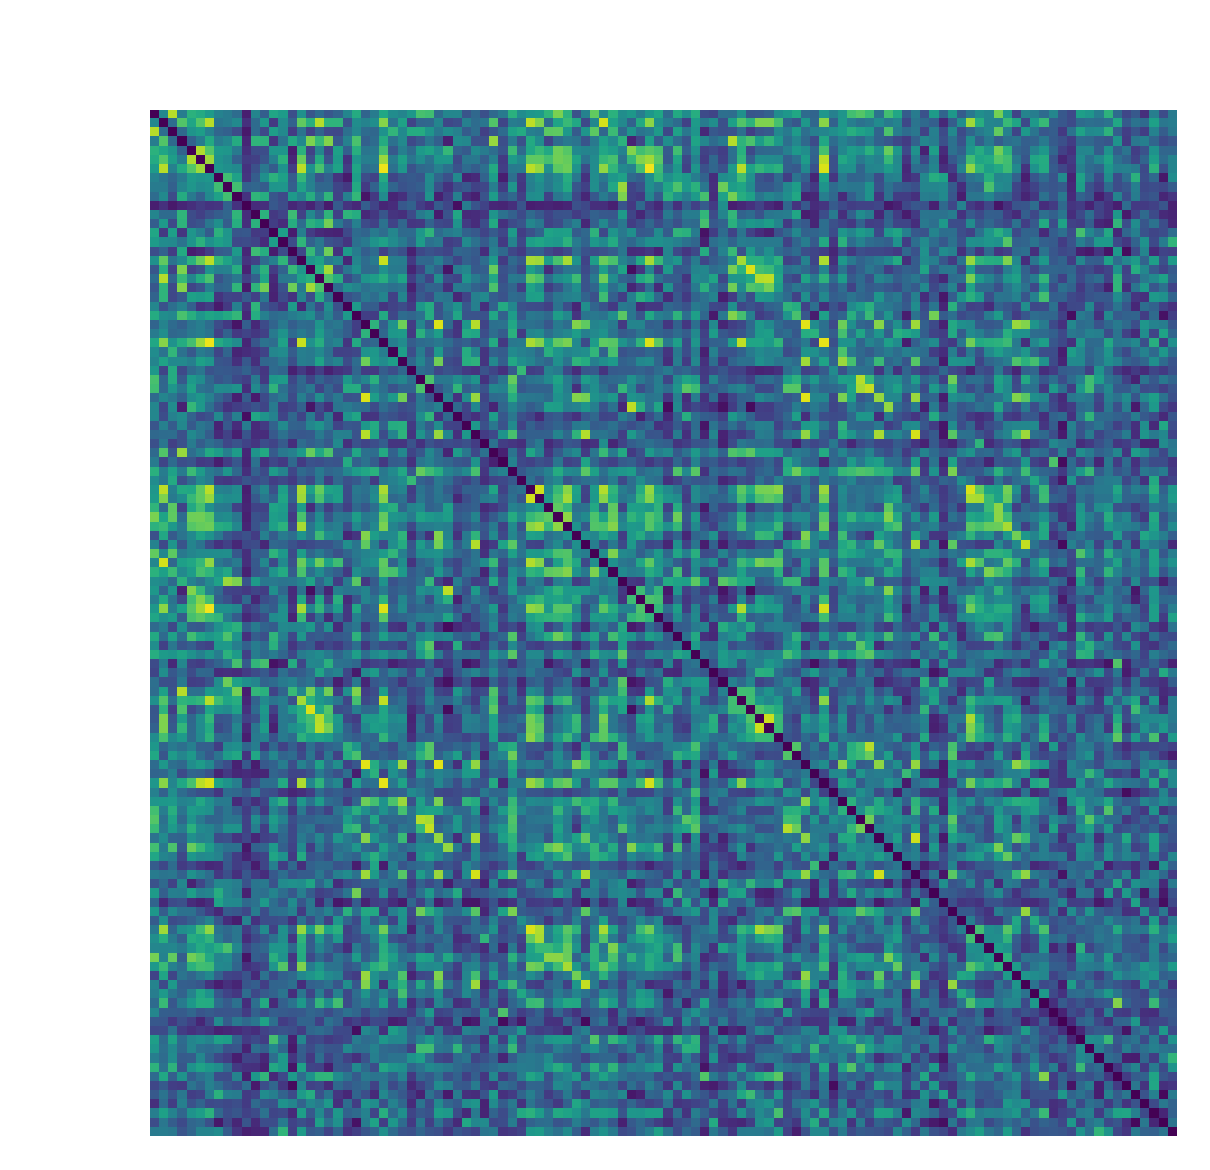

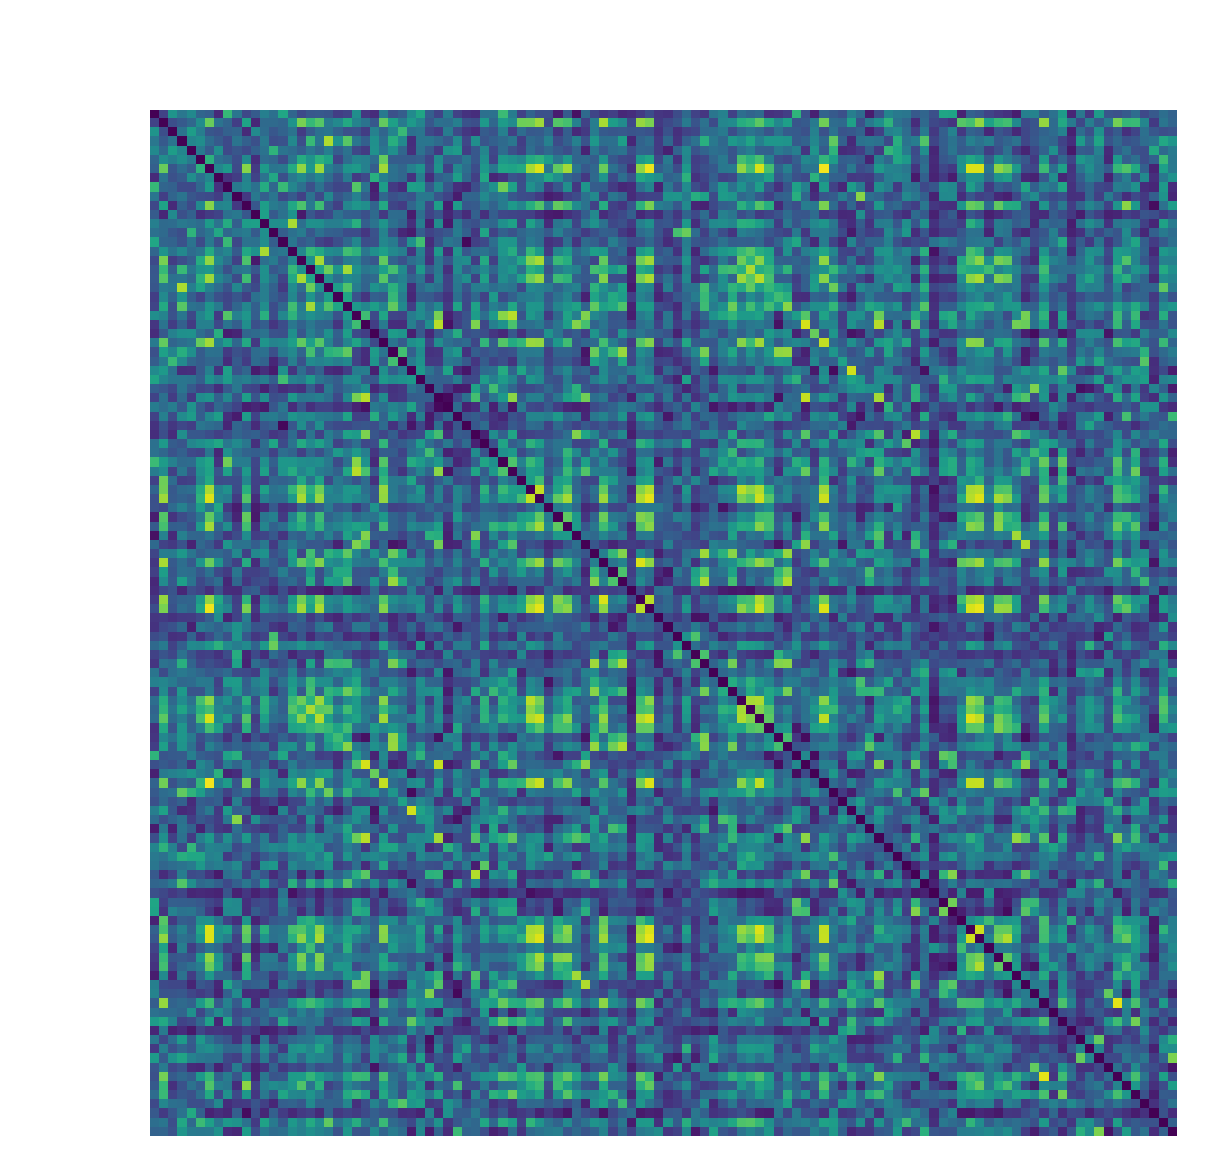

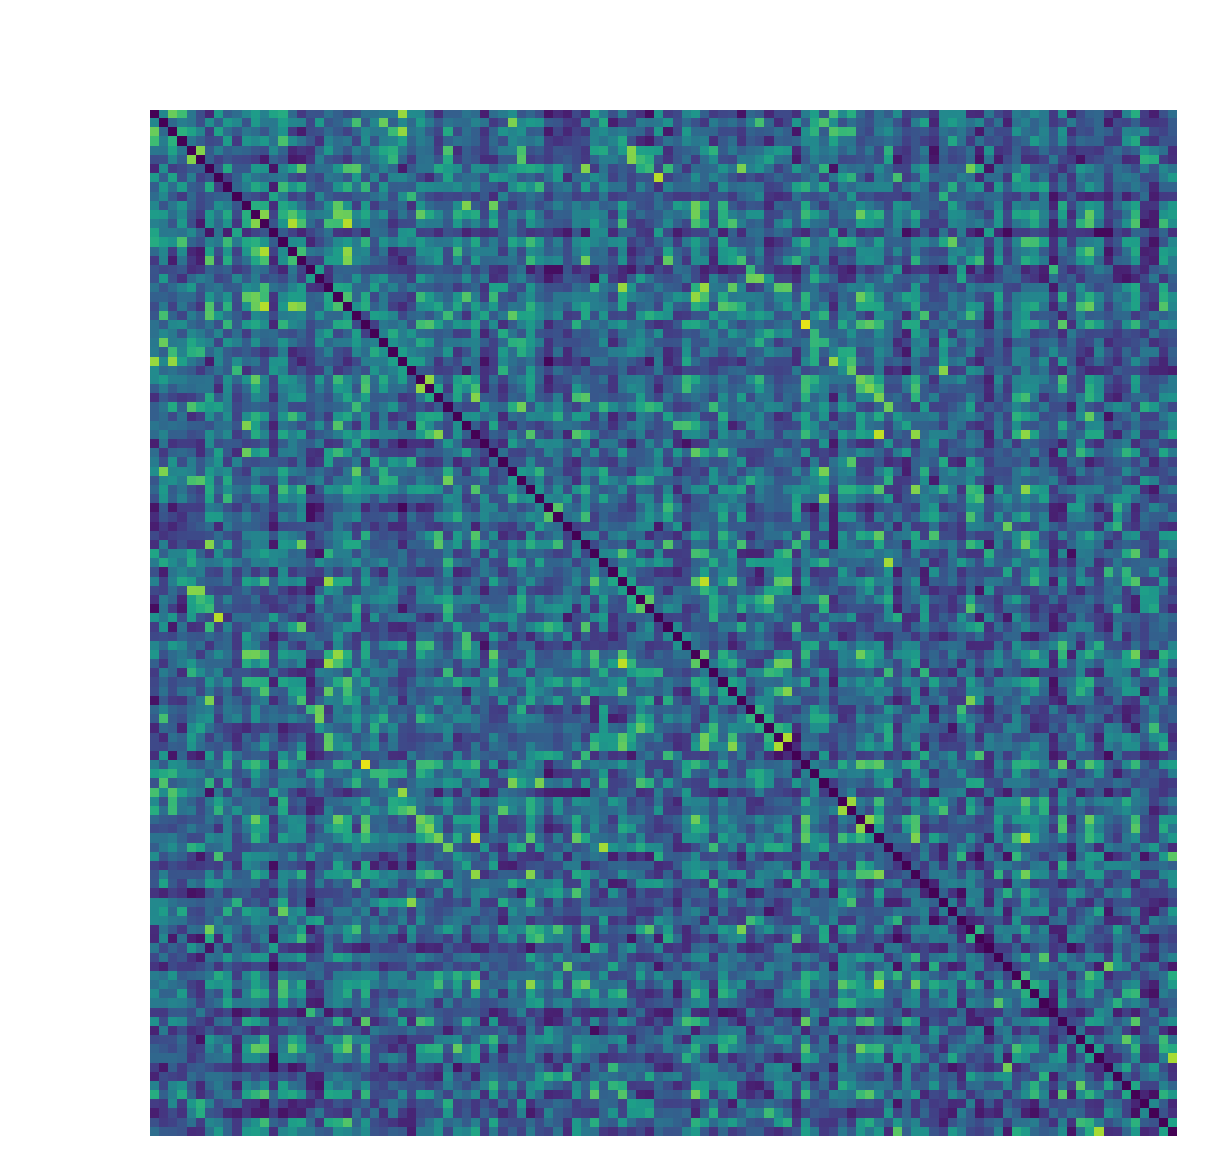

In [46]:
# Get list of Output Files
adj_paths = glob.glob('{}/Adjacency.*.npz'.format(path_ExpData))
adj_path = np.random.permutation(adj_paths)[0]

# Figure
%matplotlib inline
plt.figure()
for ix, ii in enumerate([0, 1, -1]):
       
    df = np.load(adj_path)
    data = df['adj_matr'][ix, :, :]
    df.close()

    plt.figure()
    ax = plt.subplot(111)
    mat = ax.matshow(data, cmap='viridis', vmin=0, vmax=1)
    ax.set_axis_off()
    
    plt.savefig('./e01-Figures/Sample_Adjacency_{}.svg'.format(ix+1))
    plt.show()
    plt.close()  

### Plot Configuration Matrix

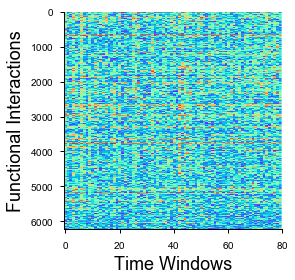

In [69]:
# Get list of DyNe Output Files
dyne_outp = glob.glob("{}/*.dyne_output.hdf".format(path_ExpData))
dyne_logs = glob.glob("{}/*.dyne_log.csv".format(path_ExpData))

outp, log = np.random.permutation(zip(dyne_outp, dyne_logs))[0]

# Figure
%matplotlib inline
ix = 0
for subj, dates in subj_ids.items():
    for date_id in dates:
        outp = '{}/{}.{}.dyne_output.hdf'.format(path_ExpData, subj, date_id)
        log = '{}/{}.{}.dyne_log.csv'.format(path_ExpData, subj, date_id)        
    
        df_log = pd.read_csv(log, delimiter=',')
        pipe_hash = df_log[df_log.PIPE_NAME == 'MTCoh'].DOWNSTREAM_HASH[0]

        df_outp = h5py.File(outp, 'r')
        data = df_outp[pipe_hash]['data'][...]
        df_outp.close()

        triu_ix, triu_iy = np.triu_indices(data.shape[1], k=1)
        if ix == 0:
            cfg_matr = data[:, triu_ix, triu_iy]            
        else:
            cfg_matr = np.vstack((cfg_matr, data[:, triu_ix, triu_iy]))
        ix += 1
    break
    
n_win = cfg_matr.shape[0]
n_conn = cfg_matr.shape[1]

plt.figure()
ax = plt.subplot(111)
mat = ax.matshow(cfg_matr.T, aspect=n_win/n_conn, cmap='rainbow', vmin=0, vmax=1)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.linspace(0, 80, 5))
ax.set_ylabel('Functional Interactions')
ax.set_xlabel('Time Windows')

plt.savefig('./e01-Figures/Sample_Configuration_Matrix.svg')
plt.show()
plt.close()  